In [2]:
import torch
import torch.nn as nn
import numpy as np
from spikingjelly.clock_driven import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt
from functools import lru_cache

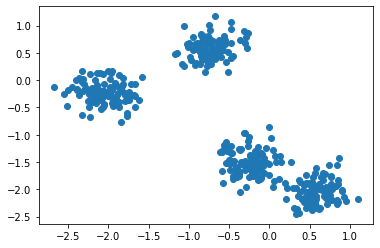

In [27]:
x1=np.random.normal(0,1,(4,2))
# concatenate two 2d vectors
x1=np.concatenate(([x1+np.random.normal(0,0.01,x1.shape) for _ in range(100)]),axis=0)
x1=x1+np.random.normal(0,0.2,x1.shape)
x1=x1[np.random.permutation(len(x1))]
y1=np.ones(x1.shape[0])
plt.scatter(x1[:,0],x1[:,1])

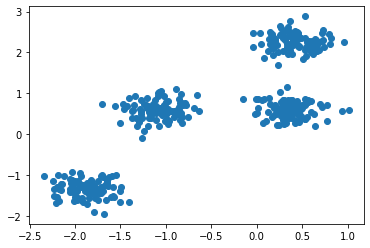

In [29]:
x2=np.random.normal(0,1,(4,2))
# concatenate two 2d vectors
x2=np.concatenate(([x2+np.random.normal(0,0.01,x2.shape) for _ in range(100)]),axis=0)
x2=x2+np.random.normal(0,0.2,x2.shape)
x2=x2[np.random.permutation(len(x2))]
y2=np.ones(x2.shape[0])
plt.scatter(x2[:,0],x2[:,1])

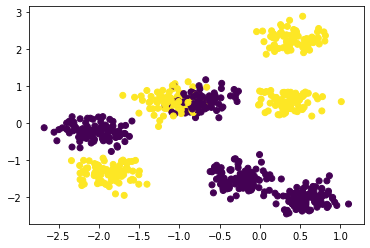

In [30]:
y1=np.array([np.zeros(y2.shape[0]),y1]).T
y2=np.array([y2,np.zeros(y1.shape[0])]).T
y=np.concatenate((y1,y2),axis=0)
x=np.concatenate((x1,x2),axis=0)

a=np.random.permutation(int(x.shape[0]/1.1))
x=x[a]
y=y[a]
y=y[~np.isnan(x).any(axis=1)]
x=x[~np.isnan(x).any(axis=1)]
plt.scatter(x[:,0],x[:,1],c=y[:,0])

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2=nn.Linear(4, 4)
        self.fc3=nn.Linear(4, 4)
        self.fc4=nn.Linear(4, 4)
        self.fc5 = nn.Linear(4, 2)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)

        x = self.fc5(x)
        x = torch.sigmoid(x)
        return x

model = Net()
#train model on x and y
optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)
loss_func = nn.MSELoss()
for epoch in range(3000):
    prediction = model(torch.from_numpy(x).float())
    loss = loss_func(prediction, torch.from_numpy(y).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

Epoch:  0 | train loss: 0.2484
Epoch:  200 | train loss: 0.0326
Epoch:  400 | train loss: 0.0345
Epoch:  600 | train loss: 0.0318
Epoch:  800 | train loss: 0.0316
Epoch:  1000 | train loss: 0.0333
Epoch:  1200 | train loss: 0.0320
Epoch:  1400 | train loss: 0.0317
Epoch:  1600 | train loss: 0.0318
Epoch:  1800 | train loss: 0.0319
Epoch:  2000 | train loss: 0.0316
Epoch:  2200 | train loss: 0.0316
Epoch:  2400 | train loss: 0.0320
Epoch:  2600 | train loss: 0.0316
Epoch:  2800 | train loss: 0.0318


In [33]:
del a,epoch,loss,loss_func, optimizer, prediction, x1, y1, x2, y2

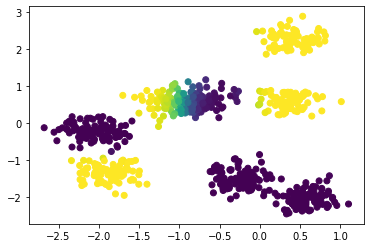

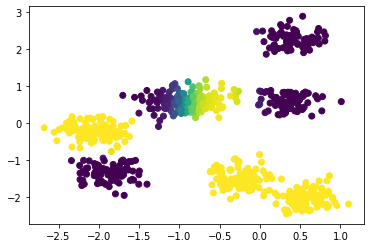

In [34]:
plt.scatter(x[:,0],x[:,1],c=model(torch.from_numpy(x).float()).data.numpy()[:,0])
plt.show()
plt.scatter(x[:,0],x[:,1],c=model(torch.from_numpy(x).float()).data.numpy()[:,1])
plt.show()

In [35]:
class Layer:
    def __init__(self, w, b, alt_n=False):
        self.W=w
        self.U=np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.b=b
        self.N=self.U.copy()
        self.neuron_f=self.aif_neuron if alt_n else self.if_neuron
        self.history_U=[self.U.copy()]
        self.history_S=[self.N.copy()]
        self.history_N=[self.N.copy()]

    def reset(self):
        self.U=np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.N=self.U.copy()

    def simulate(self, inp):
        a=self.SS(inp)
        self.history_U.append(self.U.copy())
        self.history_S.append(self.spiked)
        self.history_N.append(self.N.copy())
        return a

    def simulate_c(self, inp):
        a=self.SC(inp)
        self.history_U.append(self.U.copy())
        self.history_S.append(self.spiked.copy())
        self.history_N.append(self.N.copy())
        return a

    def SS(self, inp):
        r_inp=(np.dot(self.W,inp.copy())+self.b)
        self.U+=r_inp
        spiked=self.U>1
        self.spiked=spiked
        if not spiked.any(): return spiked
        return self.neuron_f(spiked)

    def SC(self, inp):
        self.N+=np.dot(self.W,inp.copy())+self.b
        self.U+=np.dot(self.W,inp.copy())+self.b
        self.spiked=np.dot(self.W,inp.copy())+self.b
        return self.N

    def if_neuron(self,spiked):
        self.N+=spiked
        self.U[spiked]-=1
        return spiked

    def aif_neuron(self,spiked):
        output=spiked*(self.U//1)
        self.N+=output
        self.U[spiked]%=1
        return output

    def abstract_n(self, x, t, c=False, f=lambda x:np.floor(x)):
        if len(np.array(x).shape)==2:
            return np.array([self.abstract_n(xx,t) for xx in x])
        a=np.dot(self.W,x.copy())+self.b*t
        if c: return a
        a*=a>0
        return f(a)

    def plot_history(self,lim):
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_U)), self.history_U, label='U')
        plt.scatter(np.arange(len(self.history_S)), np.array(self.history_S).sum(axis=1)*3-2, label='S')
        plt.ylim(-0.1,max(np.max(self.history_U)+0.1,1.1))
        plt.xlim(0,lim)
        plt.grid()
        plt.show()
        # plt.rcParams['figure.figsize'] = (20, 10)
        # plt.xlim(0,lim)
        # plt.show()
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_N)), np.array(self.history_N), label='N')
        plt.xlim(0,lim)
        plt.show()

class SNN:
    def __init__(self, w, b, fin_act=lambda x:x,alt_n=False):
        w=w; b=b
        self.layers=[Layer(w[m],b[m], alt_n=alt_n) for m in range(len(w))]
        self.layers[-1].simulate=self.layers[-1].simulate_c
        self.final_activation=fin_act

    def reset(self):
        for l in self.layers: l.reset()

    def __call__(self, x, t=1):
        if len(x.shape)==1:
            out=self.predict(x, t).copy()
            self.reset()
            return out
        if len(x.shape)!=2: raise ValueError('x must be a vector or 2D matrix')

        out=[]
        for i in range(x.shape[0]):
            out.append(self.predict(x[i], t).copy())
            self.reset()
        return np.array(out)

    def forward(self, x):
        layer_out=x.copy()
        for i, l in enumerate(self.layers):
            layer_out=l.simulate(layer_out)
        return layer_out

    def predict(self, x, t):
        for _ in range(t): self.forward(x)
        return self.final_activation(self.layers[-1].N/t)

    def abstract_n(self, x, t):
        x=x.copy()*t
        for l in self.layers[:-1]:
            x=l.abstract_n(x, t)
        x=self.layers[-1].abstract_n(x, t, c=True)
        return self.final_activation(x/t)

    def abstract_n_layer(self, x, t, lim, f=lambda x:np.floor(x)):
        x=x.copy()*t
        for l in self.layers[:lim]: x=l.abstract_n(x, t)
        x=self.layers[lim].abstract_n(x, t, f=f)
        return x

    def plot_history(self,lim=None):
        for i,l in enumerate(self.layers):
            print(i+2)
            l.plot_history(lim)

w=list(model.parameters())
wb=[[w[i].data.numpy().copy() for i in range(0,len(w),2)], [w[i].data.numpy().copy() for i in range(1,len(w),2)]]

snn_model=SNN(wb[0],wb[1], fin_act=lambda x: 1/(1+np.exp(-x)), alt_n=True)

xx=x.astype('float64')[3]
t=2
print(model(torch.from_numpy(xx.copy()).float()).data.numpy()*1000//1/1000)
print(snn_model(xx,t)*1000//1/1000)
print(snn_model.abstract_n(xx,t)*1000//1/1000)
snn_model.plot_history()

In [136]:
def get_new_weights(x,wb,model):
    a=[torch.from_numpy(x.copy()).float()]
    b=[torch.from_numpy(x.copy()).float()]
    for i in range(len(wb[0])):
        a.append(eval('model.fc%s(b[-1])'%(i+1)))
        b.append(torch.relu(a[-1]))
    b.pop(-1)
    b.append(torch.sigmoid(a[-1]-5))
    for i in range(len(a)):
        a[i]=a[i].data.numpy().copy()
        b[i]=b[i].data.numpy().copy()
    a.pop(0); b.pop(0)

    f=lambda x: x.max() #np.percentile(abs(x).max(),99.9)
    wb=wb.copy()
    for i in range(len(wb[0])):
        for j in range(len(wb[0][i])):
            if i==len(wb[0])-1: continue
            m=a[i][:,j]
            if max(m)<=0: continue
            wb[0][i][j]/=f(m)
            wb[1][i][j]/=f(m)

        for j in range(len(wb[0][i].T)):
            if i==0: continue
            m=a[i-1][:,j]
            if max(m)<=0: continue
            wb[0][i][:,j]*=f(m)

    return wb, (a,b)

w=list(model.parameters())
wb=[[w[i].data.numpy().copy() for i in range(0,len(w),2)], [w[i].data.numpy().copy() for i in range(1,len(w),2)]]
wb, ab=get_new_weights(x,wb,model)
t=1
snn_model=SNN(wb[0],wb[1], fin_act=lambda x:1/(1 + np.exp(-x)))

print(model(torch.from_numpy(xx.copy()).float()).data.numpy()*1000//1/1000)
print(snn_model(xx,t)*1000//1/1000)
print(snn_model.abstract_n(xx,t)*1000//1/1000)
# snn_model.plot_history(150)

[0.016 0.983]
[0.991 0.008]
[0.023 0.976]


In [ ]:
def fft_u(y,t):
    from scipy.fftpack import fft
    # Number of sample points
    N = t
    # sample spacing
    T = 1.0
    x = np.arange(N)
    yf = fft(y,)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = (30, 10)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.ylim(0,0.25)
    plt.show()
fft_u(np.array(snn_model.layers[3].history_U[1:])[:,3],t)

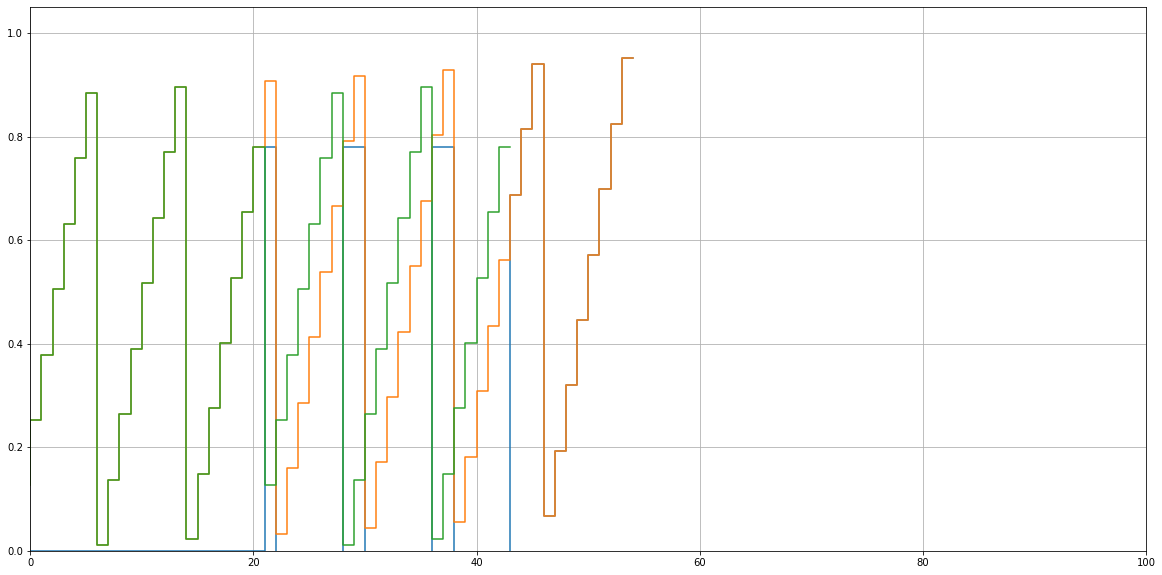

In [107]:
ll=0;ln=3
l_h_u=np.array(snn_model.layers[ll].history_U[1:])[:,ln]
h_s=l_h_u.copy()
br=22
sub_h_s=l_h_u[0:br].copy()
for i in np.arange(br,t,br):
    h_s[i-br:i]-=sub_h_s

layer=snn_model.layers[0]; x_lim=100
plt.rcParams['figure.figsize'] = (20, 10)
plt.step(np.arange(len(h_s)), list(zip(h_s,l_h_u)), label='S')
plt.step(np.arange(len(list(sub_h_s)*(t//br))),list(sub_h_s)*(t//br))
plt.xlim(0,x_lim)
plt.ylim(0,1.05)
plt.grid()
plt.show()

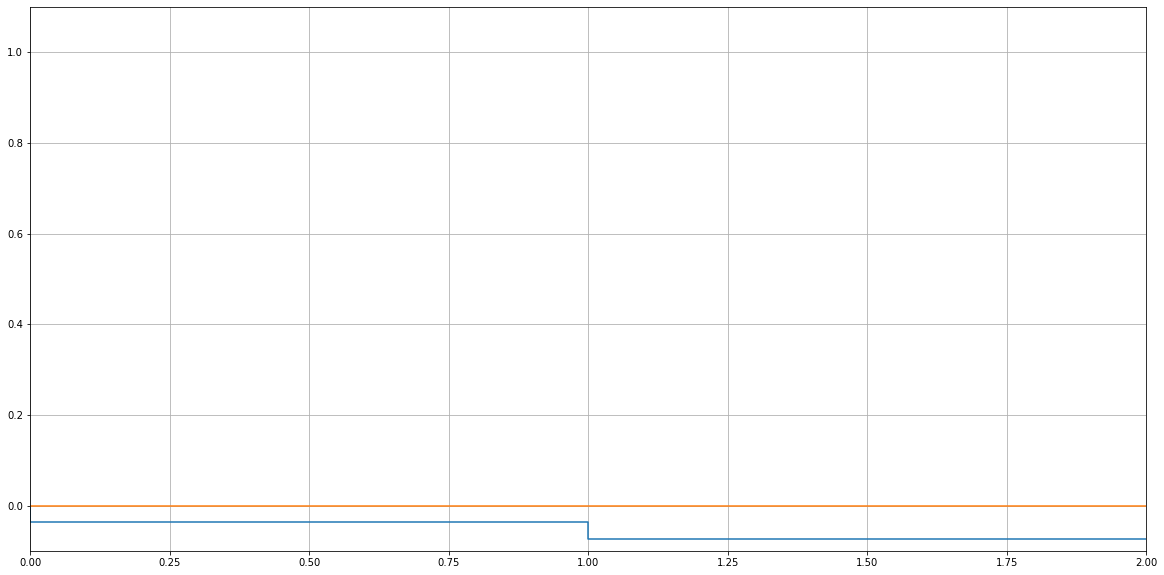

In [134]:
ll,ln,lim_b,lim_a=0,2,0,2
l_h_u=np.array(snn_model.layers[ll].history_U)[:,ln]
snn_model.reset()
N=lambda zz: snn_model.abstract_n_layer(xx,zz,ll)[ln]
kN=lambda zz: snn_model.abstract_n_layer(xx,zz,ll,f=lambda x:x)[ln]
plt.rcParams['figure.figsize'] = (20, 10)
plt.step(np.arange(len(l_h_u)), l_h_u)
plt.step(np.arange(len(l_h_u)), [kN(tt)-N(tt) for tt in range(len(l_h_u))])
plt.scatter(np.arange(len(l_h_u)), np.array(snn_model.layers[ll].history_S)[:,ln]*5-4)
plt.xlim(lim_b,lim_a)
plt.ylim(-0.1,1.1)
plt.grid()
plt.show()

In [64]:
class Layer:
    def __init__(self, w, b, abst_func=lambda x: np.floor(max(x,0))):
        self.W=w
        self.U=np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.b=b
        self.N=self.U.copy()
        self.abs_func=abst_func

        self.history_U=[self.U.copy()]
        self.history_S=[self.N.copy()]

    def reset(self):
        self.U=np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.N=self.U.copy()

        self.history_U=[self.U.copy()]
        self.history_S=[self.N.copy()]

    def forward(self, inp):
        x, spiked=self.simulate(inp)
        self.history_U.append(self.U.copy())
        self.history_S.append(spiked.copy())
        return x

    def simulate(self, inp):
        self.U=self.W.T[inp].sum(axis=1)+self.b
        spiked=self.U>1
        return self.neuron_func(spiked), spiked

    def neuron_func(self,spiked):
        if not spiked.any(): return spiked, spiked
        self.N+=spiked
        self.U[spiked]-=1
        return spiked

    def abstract_n(self, inp, t):
        if len(np.array(inp).shape)==2:
            return np.array([self.abstract_n(xx,t) for xx in inp])
        return self.abs_func(self.W[inp].sum(axis=1)+self.b*t)

    def abstract_v(self, inp, t):
        if len(np.array(inp).shape)==2:
            return np.array([self.abstract_v(xx,t) for xx in inp])
        return self.W[inp].sum(axis=1)+self.b*t - self.abstract_n(inp,t)

    def plot_history(self,lim):
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_U)), self.history_U, label='U')
        plt.scatter(np.arange(len(self.history_S)), np.array(self.history_S).sum(axis=1)*3-2, label='S')
        plt.ylim(-0.1,max(np.max(self.history_U)+0.1,1.1))
        plt.xlim(0,lim)
        plt.grid()
        plt.show()

        history_N=[self.history_S[0:tt].sum(axis=1) for tt in range(len(self.history_S))]
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_S)), np.array(history_N), label='N')
        plt.xlim(0,lim)
        plt.show()

class InputLayer(Layer):
    def __init__(self, w, b, abst_func=lambda x:x):
        super(InputLayer, self).__init__(w, b, abst_func)

    def simulate(self, inp):
        self.U=np.dot(self.W,inp)+self.b
        spiked=self.U>1
        return self.neuron_func(spiked), spiked

class AlterLayer(Layer):
    def neuron_func(self,spiked):
        if not spiked.any(): return spiked, spiked
        output=spiked*(self.U//1)
        self.N+=output
        self.U[spiked]%=1
        return output

class OutLayer(Layer):
    def neuron_func(self,spiked):
        self.N+=spiked
        self.U=spiked
        return spiked

class SNN:
    def __init__(self, w, b, fin_act=lambda x:x, layer_type=Layer):
        w=w; b=b
        self.layers=[InputLayer(w[0],b[0])]+[layer_type(w[m],b[m]) for m in range(1,len(w)-2)]+[OutLayer(w[-1],b[-1])]
        self.final_activation=fin_act

    def reset(self):
        for l in self.layers: l.reset()

    def __call__(self, x, t=1):
        if len(x.shape)==1:
            out=self.predict(x, t).copy()
            self.reset()
            return out
        if len(x.shape)!=2: raise ValueError('x must be a vector or 2D matrix')

        out=[]
        for i in range(x.shape[0]):
            out.append(self.predict(x[i], t).copy())
            self.reset()
        return np.array(out)

    def forward(self, x):
        layer_out=x.copy()
        for i, l in enumerate(self.layers):
            layer_out=l.simulate(layer_out)
        return layer_out

    def predict(self, x, t):
        for _ in range(t): self.forward(x)
        return self.final_activation(self.layers[-1].N/t)

    def abstract_n_layer(self, x, t, lim):
        for l in self.layers[:lim]: x=l.abstract_n(x.copy()*t, t)
        return x

    def abstract_n(self, x, t):
        return self.final_activation(self.abstract_n_layer(x,t,len(self.layers))/t)

    def abstract_v_layer(self, x, t, lim):
        for l in self.layers[:lim]: x=l.abstract_v(x.copy()*t, t)
        return x

    def abstract_v(self, x, t):
        return self.final_activation(self.abstract_v_layer(x,t,len(self.layers))/t)

In [65]:
w=list(model.parameters())
wb=[[w[i].data.numpy().copy() for i in range(0,len(w),2)], [w[i].data.numpy().copy() for i in range(1,len(w),2)]]

snn_model=SNN(wb[0],wb[1], fin_act=lambda x: 1/(1+np.exp(-x)))

xx=x.astype('float64')[0]
t=2
print(model(torch.from_numpy(xx.copy()).float()).data.numpy()*1000//1/1000)
print(snn_model(xx,t)*1000//1/1000)
print(snn_model.abstract_n(xx,t)*1000//1/1000)
snn_model.plot_history()

[0.999 0.   ]


AxisError: axis 1 is out of bounds for array of dimension 1

In [46]:
wb[0][0][:,:]

array([[-1.4608976 , -0.00510058],
       [-0.7791851 ,  1.0173801 ],
       [ 0.34891254, -0.04383981],
       [ 0.8632294 ,  1.1348292 ]], dtype=float32)

In [ ]:
w=list(model.parameters())
wb=[[w[i].data.numpy().copy() for i in range(0,len(w),2)], [w[i].data.numpy().copy() for i in range(1,len(w),2)]]
wb, ab=get_new_weights(x,wb,model)
t=1
snn_model=SNN(wb[0],wb[1], fin_act=lambda x:1/(1 + np.exp(-x)))

print(model(torch.from_numpy(xx.copy()).float()).data.numpy()*1000//1/1000)
print(snn_model(xx,t)*1000//1/1000)
print(snn_model.abstract_n(xx,t)*1000//1/1000)
# snn_model.plot_history(150)